<a href="https://colab.research.google.com/github/ylu149/Temperature-Prediction/blob/main/ML_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data was downlaoded from: https://nsrdb.nrel.gov/data-viewer?fbclid=IwAR1fS7e06UkcSS8xOlFZksjbAemMYXQLMdbBYBWNv2b2y3v9MToz9hmLkHM.

Everything was saved to ML_30_data.zip. Please upload all excel files in that folder to run code.

In [1]:
#Loading in all excel files
from google.colab import files
uploaded = files.upload()


Saving 1245245_40.73_-73.98_1998.csv to 1245245_40.73_-73.98_1998.csv
Saving 1245245_40.73_-73.98_1999.csv to 1245245_40.73_-73.98_1999.csv
Saving 1245245_40.73_-73.98_2000.csv to 1245245_40.73_-73.98_2000.csv
Saving 1245245_40.73_-73.98_2001.csv to 1245245_40.73_-73.98_2001.csv
Saving 1245245_40.73_-73.98_2002.csv to 1245245_40.73_-73.98_2002.csv
Saving 1245245_40.73_-73.98_2003.csv to 1245245_40.73_-73.98_2003.csv
Saving 1245245_40.73_-73.98_2004.csv to 1245245_40.73_-73.98_2004.csv
Saving 1245245_40.73_-73.98_2005.csv to 1245245_40.73_-73.98_2005.csv
Saving 1245245_40.73_-73.98_2006.csv to 1245245_40.73_-73.98_2006.csv
Saving 1245245_40.73_-73.98_2007.csv to 1245245_40.73_-73.98_2007.csv
Saving 1245245_40.73_-73.98_2008.csv to 1245245_40.73_-73.98_2008.csv
Saving 1245245_40.73_-73.98_2009.csv to 1245245_40.73_-73.98_2009.csv
Saving 1245245_40.73_-73.98_2010.csv to 1245245_40.73_-73.98_2010.csv
Saving 1245245_40.73_-73.98_2011.csv to 1245245_40.73_-73.98_2011.csv
Saving 1245245_40.73

# Machine Learning Regression Analaysis

In [2]:
#loading all excel data to a list of pandas df
from numpy import iinfo
import io
import pandas as pd

yearRange = range(2000, 2023)
weatherDF = {}
numberHeaderLines = 2
csvStr = "1245245_40.73_-73.98_"

for year in yearRange:
  fileStr = csvStr + str(year) + ".csv"
  weatherDF[year] = pd.read_csv(io.BytesIO(uploaded[fileStr]), skiprows = numberHeaderLines)

#Adding a Timestamp and Ordinal time and deleting original time format
for year, df in weatherDF.items():
    df.insert(0, "Timestamp", pd.to_datetime(df[["Year", "Month", "Day", "Hour", "Minute"]]), True)
    df.insert(1, "OrdinalTime", df["Timestamp"].apply(lambda x: x.toordinal()), True)
    df.drop(["Year", "Month", "Day", "Hour", "Minute"], axis=1, inplace = True)
    ColOrder = ["Timestamp", "Temperature", "OrdinalTime", "Relative Humidity", "Pressure", "Dew Point", "Wind Speed"]
    weatherDF[year] = df[ColOrder]

#Combining all data frames into 1 and get sample data
weatherAll = pd.concat(weatherDF.values(), ignore_index=True)


#gets the max temp of each day and added a max temp column
grouped_by_date = weatherAll.groupby(weatherAll['Timestamp'].dt.date)
max_temperatures = grouped_by_date['Temperature'].transform('max')
weatherAll.insert(2, "Max Temperature", max_temperatures.values, True)

weatherAll.insert(8, "target temperature", weatherAll['Max Temperature'].shift(-48), True)
weatherAll = weatherAll[:-48]
weatherAll.head()

,Timestamp,Temperature,Max Temperature,OrdinalTime,Relative Humidity,Pressure,Dew Point,Wind Speed,target temperature
0,2000-01-01 00:00:00,0.6,7.5,730120,87.21,1018,-1.3,1.4,8.3
1,2000-01-01 00:30:00,0.5,7.5,730120,87.84,1018,-1.3,1.4,8.3
2,2000-01-01 01:00:00,0.4,7.5,730120,90.30,1019,-1.0,1.5,8.3
3,2000-01-01 01:30:00,0.3,7.5,730120,90.96,1019,-1.0,1.6,8.3
4,2000-01-01 02:00:00,0.3,7.5,730120,92.65,1019,-0.8,1.6,8.3


In [3]:
#Checking for NaN Values in csv
for ii in weatherAll:
  check_nan = weatherAll[ii].isnull().values.any()
  print(ii, ": ", check_nan)

Timestamp :  False
Temperature :  False
Max Temperature :  False
OrdinalTime :  False
Relative Humidity :  False
Pressure :  False
Dew Point :  False
Wind Speed :  False
target temperature :  False


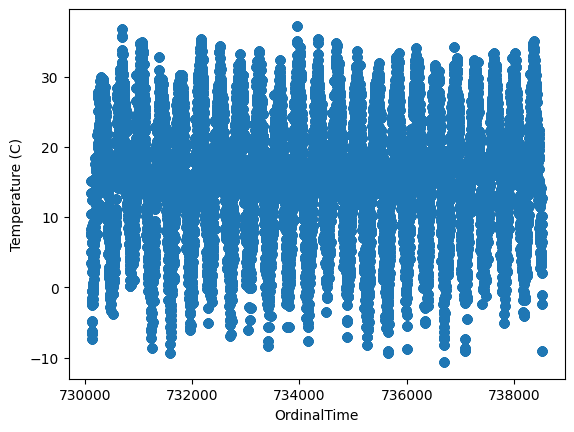

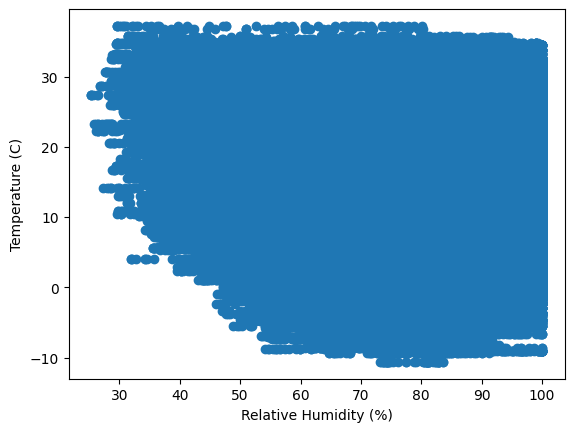

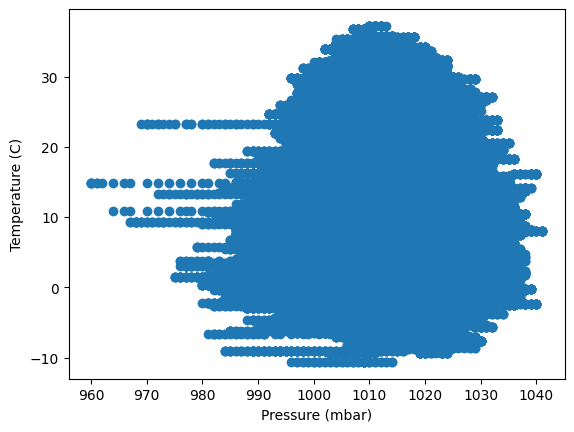

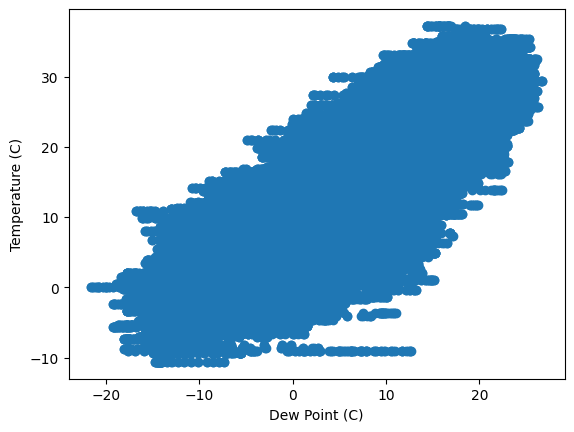

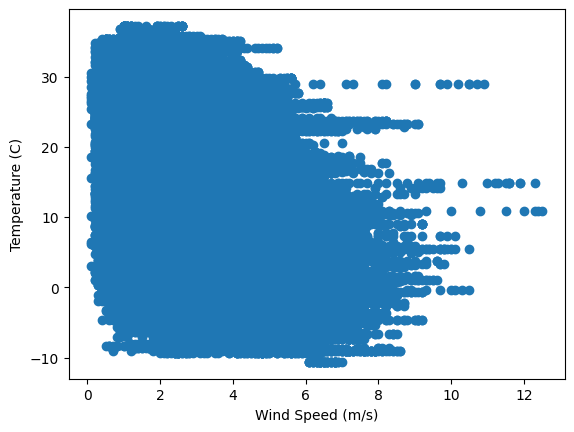

In [4]:
#Getting a plot of all tempearture vs all the features
import matplotlib.pyplot as plt
xLabel = {
    2: "Max Temperature (C)",
    3: "OrdinalTime",
    4: "Relative Humidity (%)",
    5: "Pressure (mbar)",
    6: "Dew Point (C)",
    7: "Wind Speed (m/s)"
  }

df = weatherAll

for ii in range(3, 8):
  plt.scatter(df.iloc[:, ii], df.iloc[:, 8])
  plt.xlabel(xLabel.get(ii))
  plt.ylabel("Temperature (C)")
  plt.show()


In [5]:
#Getting all needed imports from sklearn
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [6]:
#preparing data for sklearn regression
rr = Ridge(alpha = 0.1)
predictors = weatherAll.columns[~weatherAll.columns.isin(["target temperature", "Temperature", "Pressure", "Timestamp"])]
target = ["target temperature"]

weatherAll[predictors]
predictors

Index(['Max Temperature', 'OrdinalTime', 'Relative Humidity', 'Dew Point',
       'Wind Speed'],
      dtype='object')

In [7]:
#Credits: https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn
#preparing test set and training set
x = weatherAll[predictors].values
y = weatherAll[target].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=40, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(282038, 5)
(120874, 5)


Lasso Regression
Mean Squared Error Training Data:  3.0934802079319663
R2 Score Training Data: 0.9022720673484452 

Mean Squared Error Test Data:  3.2189737938333383
R2 Score Training Data: 0.8889448986289141


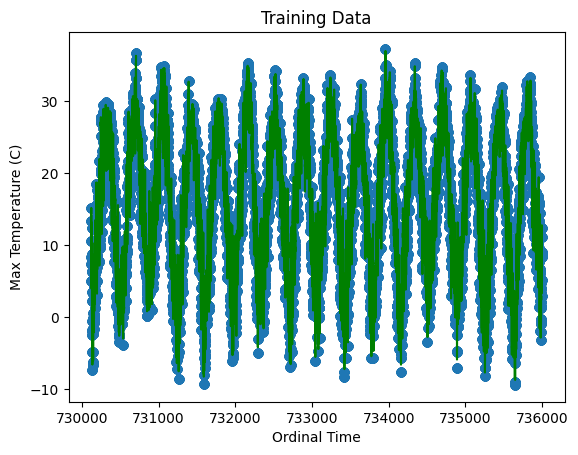

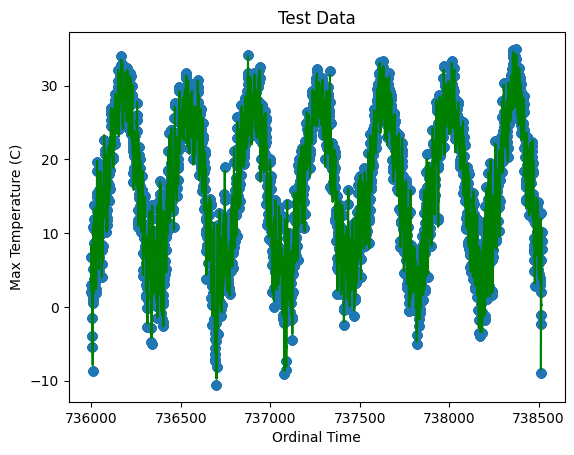

In [8]:
#Lasso regression
print("Lasso Regression")
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train)
pred_train_lasso = model_lasso.predict(X_train)
print("Mean Squared Error Training Data: ",np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print("R2 Score Training Data:",r2_score(y_train, pred_train_lasso),"\n")

pred_test_lasso = model_lasso.predict(X_test)
print("Mean Squared Error Test Data: ",np.sqrt(mean_squared_error(y_test,pred_test_lasso)))
print("R2 Score Training Data:", r2_score(y_test, pred_test_lasso))

plt.title("Training Data")
plt.xlabel("Ordinal Time")
plt.ylabel("Max Temperature (C)")
plt.plot(X_train[:, 1], pred_train_lasso, color='green')
plt.scatter(X_train[:, 1], y_train, color='C0')
plt.show()

plt.title("Test Data")
plt.xlabel("Ordinal Time")
plt.ylabel("Max Temperature (C)")
plt.plot(X_test[:, 1], pred_test_lasso, color='green')
plt.scatter(X_test[:, 1], y_test, color='C0')
plt.show()

Ridge Regression
Mean Squared Error Training Data: 3.0934679881198126
R2 Score Training Data: 0.9022728394333077

Mean Squared Error Test Data: 3.2185350756603364
R2 Score Test Data 0.8889751682577531


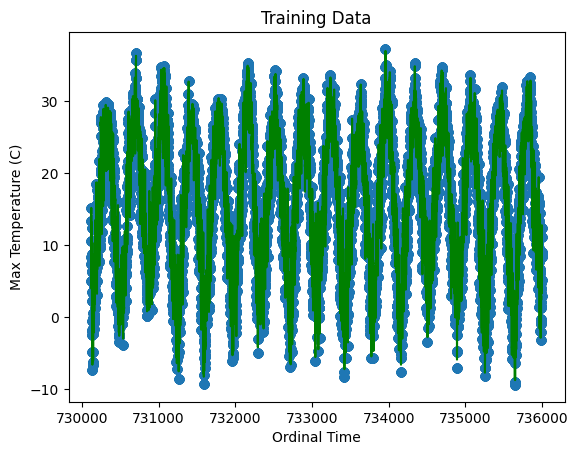

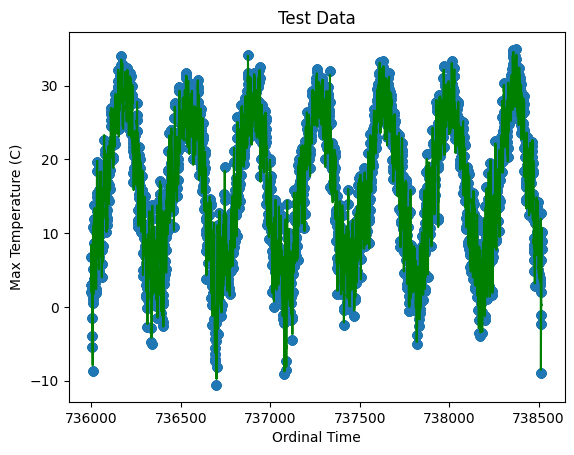

In [9]:
#ridge
print("Ridge Regression")
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train)
pred_train_rr= rr.predict(X_train)
print("Mean Squared Error Training Data:", np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print("R2 Score Training Data:", r2_score(y_train, pred_train_rr))
print();
pred_test_rr= rr.predict(X_test)
print("Mean Squared Error Test Data:", np.sqrt(mean_squared_error(y_test,pred_test_rr)))
print("R2 Score Test Data", r2_score(y_test, pred_test_rr))

plt.title("Training Data")
plt.xlabel("Ordinal Time")
plt.ylabel("Max Temperature (C)")
plt.plot(X_train[:, 1], pred_train_rr, color='green')
plt.scatter(X_train[:, 1], y_train, color='C0')
plt.show()

plt.title("Test Data")
plt.xlabel("Ordinal Time")
plt.ylabel("Max Temperature (C)")
plt.plot(X_test[:, 1], pred_test_rr, color='green')
plt.scatter(X_test[:, 1], y_test, color='C0')
plt.show()

Linear Regression
Mean Squared Error Training Data: 3.093467988119812
R2 Score Training Data: 0.9022728394333077

Mean Squared Error Test Data: 3.2185350755306588
R2 Score Test Data: 0.8889751682666996


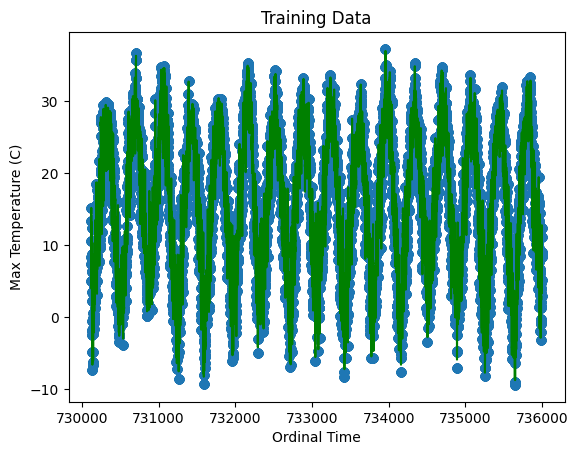

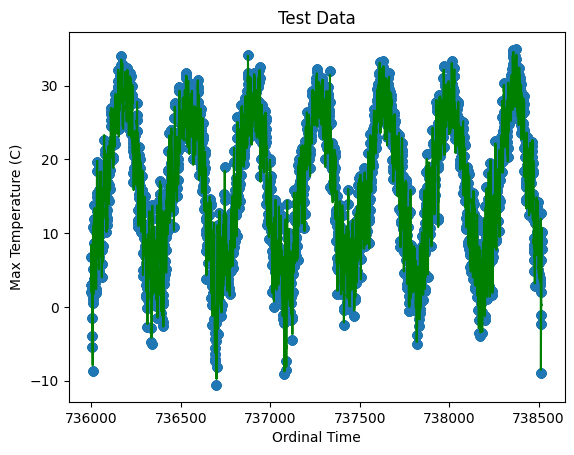

In [10]:
#linear
print("Linear Regression")
lr = LinearRegression()
lr.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)

pred_train_lr= lr.predict(X_train)
print("Mean Squared Error Training Data:", np.sqrt(mean_squared_error(y_train,pred_train_lr)))
print("R2 Score Training Data:", r2_score(y_train, pred_train_lr))
print()
pred_test_lr= lr.predict(X_test)
print("Mean Squared Error Test Data:", np.sqrt(mean_squared_error(y_test,pred_test_lr)))
print("R2 Score Test Data:", r2_score(y_test, pred_test_lr))

plt.title("Training Data")
plt.xlabel("Ordinal Time")
plt.ylabel("Max Temperature (C)")
plt.plot(X_train[:, 1], pred_train_lr, color='green')
plt.scatter(X_train[:, 1], y_train, color='C0')
plt.show()

plt.title("Test Data")
plt.xlabel("Ordinal Time")
plt.ylabel("Max Temperature (C)")
plt.plot(X_test[:, 1], pred_test_lr, color='green')
plt.scatter(X_test[:, 1], y_test, color='C0')
plt.show()

# Predicting Weather

In [11]:
#Getting API data for weather crossing
APIKey="WEATHER_CROSSING_API_KEY"

In [12]:
#Get's today's weather to predict tommorow, run only one of these blocks
#Weather crossing API was used

import urllib.request
import sys

import csv
import codecs

apiLink = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/new%20york%20city/today?unitGroup=metric&elements=datetime%2Ctemp%2Cdew%2Chumidity%2Cwindspeed%2Cpressure&include=hours&key=" + APIKey + "&contentType=csv"

try:
  ResultBytes = urllib.request.urlopen(apiLink)

  # Parse the results as CSV
  CSVText = csv.reader(codecs.iterdecode(ResultBytes, 'utf-8'))
  data_list = []
  for row in CSVText:
    data_list.append(row)
except urllib.error.HTTPError  as e:
  ErrorInfo= e.read().decode()
  print('Error code: ', e.code, ErrorInfo)
  sys.exit()
except  urllib.error.URLError as e:
  ErrorInfo= e.read().decode()
  print('Error code: ', e.code,ErrorInfo)
  sys.exit()

data_list

[['datetime', 'temp', 'dew', 'humidity', 'windspeed', 'sealevelpressure'],
 ['2023-10-12T00:00:00', '16.7', '13.8', '83.14', '5', '1012.1'],
 ['2023-10-12T01:00:00', '16.1', '12.3', '78.09', '7', '1012.2'],
 ['2023-10-12T02:00:00', '15.6', '13.3', '86.2', '7.1', '1012.3'],
 ['2023-10-12T03:00:00', '15.5', '11.6', '77.54', '0.4', '1012.1'],
 ['2023-10-12T04:00:00', '15.5', '9.4', '67.27', '0', '1012'],
 ['2023-10-12T05:00:00', '14.2', '9.4', '72.88', '0.2', '1012.3'],
 ['2023-10-12T06:00:00', '13.7', '11.1', '83.88', '5.1', '1012.7'],
 ['2023-10-12T07:00:00', '14.2', '11.1', '81.34', '0.1', '1013'],
 ['2023-10-12T08:00:00', '14.8', '12.1', '83.96', '7', '1013.4'],
 ['2023-10-12T09:00:00', '15.6', '11.7', '77.69', '8.7', '1013.5'],
 ['2023-10-12T10:00:00', '16.7', '12.2', '74.66', '9', '1013.5'],
 ['2023-10-12T11:00:00', '17.8', '11.7', '67.43', '8.6', '1013.5'],
 ['2023-10-12T12:00:00', '19.3', '11.5', '60.64', '8.9', '1013'],
 ['2023-10-12T13:00:00', '20.6', '6.8', '40.74', '5.6', '101

In [13]:
#Get's yesterday's data to predict today, run only one of these blocks
#Weather crossing API was used

import urllib.request
import sys

import csv
import codecs

apiLink = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/new%20york%20city/yesterday?unitGroup=metric&elements=datetime%2Ctemp%2Cdew%2Chumidity%2Cwindspeed%2Cpressure&include=hours&key=" + APIKey + "&contentType=csv"
try:
  ResultBytes = urllib.request.urlopen(apiLink)

  # Parse the results as CSV
  CSVText = csv.reader(codecs.iterdecode(ResultBytes, 'utf-8'))
  data_list = []
  for row in CSVText:
    data_list.append(row)

except urllib.error.HTTPError  as e:
  ErrorInfo= e.read().decode()
  print('Error code: ', e.code, ErrorInfo)
  sys.exit()
except  urllib.error.URLError as e:
  ErrorInfo= e.read().decode()
  print('Error code: ', e.code,ErrorInfo)
  sys.exit()

data_list

[['datetime', 'temp', 'dew', 'humidity', 'windspeed', 'sealevelpressure'],
 ['2023-10-11T00:00:00', '15', '9', '67.56', '5', '1011'],
 ['2023-10-11T01:00:00', '15.6', '9.3', '66.07', '4.7', '1011'],
 ['2023-10-11T02:00:00', '14.9', '9.8', '71.67', '0.3', '1010.7'],
 ['2023-10-11T03:00:00', '14.9', '10.5', '74.93', '0.3', '1010.5'],
 ['2023-10-11T04:00:00', '14.8', '10.4', '75.01', '0.3', '1010.4'],
 ['2023-10-11T05:00:00', '14.8', '9.9', '72.45', '0.1', '1010.9'],
 ['2023-10-11T06:00:00', '14.8', '10.6', '75.83', '5.1', '1011.2'],
 ['2023-10-11T07:00:00', '14.3', '10.6', '78.44', '7.1', '1011.4'],
 ['2023-10-11T08:00:00', '14.3', '9.4', '72.35', '19.1', '1011.8'],
 ['2023-10-11T09:00:00', '15.6', '10.5', '71.67', '5.1', '1012.4'],
 ['2023-10-11T10:00:00', '16.7', '9.2', '61.29', '7.6', '1012.6'],
 ['2023-10-11T11:00:00', '18.3', '9.3', '55.81', '9.5', '1012.5'],
 ['2023-10-11T12:00:00', '19.9', '8.7', '48.65', '9.7', '1012.3'],
 ['2023-10-11T13:00:00', '21.1', '6.1', '37.65', '14', '10

In [14]:
#creating a few adapter functions to convert to and from C to F
def fToC(temperatureCelcius):
  return temperatureCelcius*1.8+32
def kph2mps(kph):
  return kph * float(5/18)

In [15]:
#Preps the data grabbed above to be inputted for prediction
from datetime import datetime
yestWeather = {
    "temp": [],
    "datetime": [],
    "humidity": [],
    "dew": [],
    "windspeed": [],
    #"sealevelpressure": []
}

column_mapping = {col_name: index for index, col_name in enumerate(data_list[0])}
date_string = '2023-10-01'
date_format = '%Y-%m-%dT%H:%M:%S'
for row in data_list[1:]:
    # Convert the string to a datetime object
    date_object = datetime.strptime(row[column_mapping["datetime"]], date_format)
    yestWeather["datetime"].append(date_object.toordinal())
    yestWeather["temp"].append(float(row[column_mapping["temp"]]))
    yestWeather["dew"].append(float(row[column_mapping["dew"]]))
    yestWeather["humidity"].append(float(row[column_mapping["humidity"]]))
    yestWeather["windspeed"].append(kph2mps(float(row[column_mapping["windspeed"]])))
    #yestWeather["sealevelpressure"].append(float(row[column_mapping["sealevelpressure"]]))

In [16]:
#Gets a prediction for ridge, lasso, and linear regression based on weather data grabbed from API
import math
import datetime
from datetime import timedelta
import warnings

#Index(['Max Temperature C', 'OrdinalTime', 'Relative Humidity (%)', 'Dew Point (C)','Wind Speed (m/s)'],
maxTempYest = max(yestWeather["temp"])
temp = []

for i in range(len(yestWeather["temp"])):
  temp.append(maxTempYest)
yestWeather["temp"] = temp
data_tdy = pd.DataFrame.from_dict(yestWeather)

data_tdy = data_tdy.rename(columns={"temp": "Max Temperature", "datetime": "OrdinalTime", "humidity":"Relative Humidity", "dew": "Dew Point", "windspeed":"Wind Speed"})

lasso = fToC(model_lasso.predict(data_tdy))
ridge = fToC(rr.predict(data_tdy))
lin = fToC(lr.predict(data_tdy))

print("Ridge Regression Range:\n", min(ridge)[0], max(ridge)[0])
print()
print("Lasso Regression Range: \n", min(lasso), max(lasso))
print()
print("Linear Regression Range: \n", min(lin)[0], max(lin)[0])

val = [min(ridge)[0], max(ridge)[0], min(lasso), max(lasso), min(lin)[0], max(lin)[0]]
trueMin = int(min(val))
trueMax = int(math.ceil(max(val)))

pred_date = datetime.date.fromordinal(yestWeather["datetime"][3]) + timedelta(1)
print()
print("Overall Temperature Range: ", trueMin, '-', trueMax, "F for:", pred_date)
print()
warnings.filterwarnings('ignore')

Ridge Regression Range:
 70.52704555171789 73.33056207851459

Lasso Regression Range: 
 70.5729143346755 73.3018820202503

Linear Regression Range: 
 70.52704554742691 73.33056210955385

Overall Temperature Range:  70 - 74 F for: 2023-10-12



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


# Kalshi API

In [17]:
pip install kalshi-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 3.1 MB/s eta 0:00:00


In [18]:
#Getting kalshi imports and setting up functions for ease of use
#Note code in this section was mainly copy pasted from Kalshi's API documentation

import kalshi_python
import time
import json
import uuid
from kalshi_python.models import *
from pprint import pprint
import requests
import json
from datetime import datetime as dt
from urllib3.exceptions import HTTPError
from dateutil import parser
from typing import Any, Dict, List, Optional, Tuple
from datetime import datetime
from datetime import timedelta
import time


class KalshiClient:
    """A simple client that allows utils to call authenticated Kalshi API endpoints."""
    def __init__(
        self,
        host: str,
        email: str,
        password: str,
        token: Optional[str] = None,
        user_id: Optional[str] = None,
    ):
        """Initializes the client and logs in the specified user.
        Raises an HttpError if the user could not be authenticated.
        """

        self.host = host
        self.email = email
        self.password = password
        self.token = token
        self.user_id = user_id
        self.last_api_call = datetime.now()

    """Built in rate-limiter. We STRONGLY encourage you to keep
    some sort of rate limiting, just in case there is a bug in your
    code. Feel free to adjust the threshold"""
    def rate_limit(self) -> None:
        # Adjust time between each api call
        THRESHOLD_IN_MILLISECONDS = 100

        now = datetime.now()
        threshold_in_microseconds = 1000 * THRESHOLD_IN_MILLISECONDS
        threshold_in_seconds = THRESHOLD_IN_MILLISECONDS / 1000
        if now - self.last_api_call < timedelta(microseconds=threshold_in_microseconds):
            time.sleep(threshold_in_seconds)
        self.last_api_call = datetime.now()

    def post(self, path: str, body: dict) -> Any:
        """POSTs to an authenticated Kalshi HTTP endpoint.
        Returns the response body. Raises an HttpError on non-2XX results.
        """
        self.rate_limit()

        response = requests.post(
            self.host + path, data=body, headers=self.request_headers()
        )
        self.raise_if_bad_response(response)
        return response.json()

    def get(self, path: str, params: Dict[str, Any] = {}) -> Any:
        """GETs from an authenticated Kalshi HTTP endpoint.
        Returns the response body. Raises an HttpError on non-2XX results."""
        self.rate_limit()

        response = requests.get(
            self.host + path, headers=self.request_headers(), params=params
        )
        self.raise_if_bad_response(response)
        return response.json()

    def delete(self, path: str, params: Dict[str, Any] = {}) -> Any:
        """Posts from an authenticated Kalshi HTTP endpoint.
        Returns the response body. Raises an HttpError on non-2XX results."""
        self.rate_limit()

        response = requests.delete(
            self.host + path, headers=self.request_headers(), params=params
        )
        self.raise_if_bad_response(response)
        return response.json()

    def request_headers(self) -> Dict[str, Any]:
        headers = {"Content-Type": "application/json"}
        if self.token:
            headers["Authorization"] = self.user_id + " " + self.token
        return headers

    def raise_if_bad_response(self, response: requests.Response) -> None:
        if response.status_code not in range(200, 299):
            raise HttpError(response.reason, response.status_code)

    def query_generation(self, params:dict) -> str:
        relevant_params = {k:v for k,v in params.items() if v != None}
        if len(relevant_params):
            query = '?'+''.join("&"+str(k)+"="+str(v) for k,v in relevant_params.items())[1:]
        else:
            query = ''
        return query

class HttpError(Exception):
    """Represents an HTTP error with reason and status code."""
    def __init__(self, reason: str, status: int):
        super().__init__(reason)
        self.reason = reason
        self.status = status

    def __str__(self) -> str:
        return "HttpError(%d %s)" % (self.status, self.reason)

class ExchangeClient(KalshiClient):
    def __init__(self,
                    exchange_api_base: str,
                    email: str,
                    password: str):
        super().__init__(
            exchange_api_base,
            email,
            password,
        )

        """You must log in before making authenticated calls. We store the token and
        pass it into each call."""

        login_json = json.dumps({"email": self.email, "password": self.password})
        result = self.post(path = "/login", body = login_json)
        self.token = result["token"]
        self.user_id = result["member_id"]

        self.exchange_url = "/exchange"
        self.markets_url = "/markets"
        self.events_url = "/events"
        self.series_url = "/series"
        self.portfolio_url = "/portfolio"

    def logout(self,):
        result = self.post("/logout")
        return result

    def get_exchange_status(self,):
        result = self.get(self.exchange_url + "/status")
        return result

    # market endpoints!

    def get_markets(self,
                        limit:Optional[int]=None,
                        cursor:Optional[str]=None,
                        event_ticker:Optional[str]=None,
                        series_ticker:Optional[str]=None,
                        max_close_ts:Optional[int]=None,
                        min_close_ts:Optional[int]=None,
                        status:Optional[str]=None,
                        tickers:Optional[str]=None,
                            ):
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        dictr = self.get(self.markets_url+query_string)
        return dictr

    def get_market_url(self,
                        ticker:str):
        return self.markets_url+'/'+ticker

    def get_market(self,
                    ticker:str):
        market_url = self.get_market_url(ticker=ticker)
        dictr = self.get(market_url)
        return dictr

    def get_event(self,
                    event_ticker:str):
        dictr = self.get(self.events_url+'/'+event_ticker)
        return dictr

    def get_series(self,
                    series_ticker:str):
        dictr = self.get(self.series_url+'/'+series_ticker)
        return dictr

    def get_market_history(self,
                            ticker:str,
                            limit:Optional[int]=None,
                            cursor:Optional[str]=None,
                            max_ts:Optional[int]=None,
                            min_ts:Optional[int]=None,
                            ):
        relevant_params = {k: v for k,v in locals().items() if k!= 'ticker'}
        query_string = self.query_generation(params = relevant_params)
        market_url = self.get_market_url(ticker = ticker)
        dictr = self.get(market_url + '/history' + query_string)
        return dictr

    def get_orderbook(self,
                        ticker:str,
                        depth:Optional[int]=None,
                        ):
        relevant_params = {k: v for k,v in locals().items() if k!= 'ticker'}
        query_string = self.query_generation(params = relevant_params)
        market_url = self.get_market_url(ticker = ticker)
        dictr = self.get(market_url + "/orderbook" + query_string)
        return dictr

    def get_trades(self,
                    ticker:Optional[str]=None,
                    limit:Optional[int]=None,
                    cursor:Optional[str]=None,
                    max_ts:Optional[int]=None,
                    min_ts:Optional[int]=None,
                    ):
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        if ticker != None:
            if len(query_string):
                query_string += '&'
            else:
                query_string += '?'
            query_string += "ticker="+str(ticker)

        trades_url = self.markets_url + '/trades'
        dictr = self.get(trades_url + query_string)
        return dictr

    # portfolio endpoints!

    def get_balance(self,):
        dictr = self.get(self.portfolio_url+'/balance')
        return dictr

    def create_order(self,
                        ticker:str,
                        client_order_id:str,
                        side:str,
                        action:str,
                        count:int,
                        type:str,
                        yes_price:Optional[int]=None,
                        no_price:Optional[int]=None,
                        expiration_ts:Optional[int]=None,
                        sell_position_floor:Optional[int]=None,
                        buy_max_cost:Optional[int]=None,
                        ):

        relevant_params = {k: v for k,v in locals().items() if k != 'self' and v != None}

        print(relevant_params)
        order_json = json.dumps(relevant_params)
        orders_url = self.portfolio_url + '/orders'
        result = self.post(path = orders_url, body = order_json)
        return result

    def batch_create_orders(self,
                                orders:list
        ):
        orders_json = json.dumps({'orders': orders})
        batched_orders_url = self.portfolio_url + '/orders/batched'
        result = self.post(path = batched_orders_url, body = orders_json)
        return result

    def decrease_order(self,
                        order_id:str,
                        reduce_by:int,
                        ):
        order_url = self.portfolio_url + '/orders/' + order_id
        decrease_json = json.dumps({'reduce_by': reduce_by})
        result = self.post(path = order_url + '/decrease', body = decrease_json)
        return result

    def cancel_order(self,
                        order_id:str):
        order_url = self.portfolio_url + '/orders/' + order_id
        result = self.delete(path = order_url + '/cancel')
        return result

    def batch_cancel_orders(self,
                                order_ids:list
        ):
        order_ids_json = json.dumps({"ids":order_ids})
        batched_orders_url = self.portfolio_url + '/orders/batched'
        result = self.delete(path = batched_orders_url, body = order_ids_json)
        return result

    def get_fills(self,
                        ticker:Optional[str]=None,
                        order_id:Optional[str]=None,
                        min_ts:Optional[int]=None,
                        max_ts:Optional[int]=None,
                        limit:Optional[int]=None,
                        cursor:Optional[str]=None):

        fills_url = self.portfolio_url + '/fills'
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        dictr = self.get(fills_url + query_string)
        return dictr

    def get_orders(self,
                        ticker:Optional[str]=None,
                        event_ticker:Optional[str]=None,
                        min_ts:Optional[int]=None,
                        max_ts:Optional[int]=None,
                        limit:Optional[int]=None,
                        cursor:Optional[str]=None
                        ):
        orders_url = self.portfolio_url + '/orders'
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        dictr = self.get(orders_url + query_string)
        return dictr

    def get_order(self,
                    order_id:str):
        orders_url = self.portfolio_url + '/orders'
        dictr = self.get(orders_url + '/' +  order_id)
        return dictr

    def get_positions(self,
                        limit:Optional[int]=None,
                        cursor:Optional[str]=None,
                        settlement_status:Optional[str]=None,
                        ticker:Optional[str]=None,
                        event_ticker:Optional[str]=None,
                        ):
        positions_url = self.portfolio_url + '/positions'
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        dictr = self.get(positions_url + query_string)
        return dictr

    def get_portfolio_settlements(self,
                                    limit:Optional[int]=None,
                                    cursor:Optional[str]=None,):

        positions_url = self.portfolio_url + '/settlements'
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        dictr = self.get(positions_url + query_string)
        return dictr

In [19]:
# Logging into my Demo account on https://demo.kalshi.co/
# Testing to see if a connection can be opened and if the market is open for trading

demo_email = "KALSHI_DEMO_USER_NAME"
demo_password = "KALSHI_DEMO_PASSWORD"
demo_api_base = "https://demo-api.kalshi.co/trade-api/v2"
exchange_client = ExchangeClient(exchange_api_base = demo_api_base, email = demo_email, password = demo_password)
print(exchange_client.get_exchange_status())


{'exchange_active': True, 'trading_active': True}


In [20]:
#Grabbing all available markets for high temp in NYC

from datetime import date
from datetime import datetime
from datetime import timedelta
from pytz import timezone


#Creating string for tommorow's market
tz = timezone('EST')
tmr = datetime.now(tz) + timedelta(0) #0 for today 1 for tommorw
s_ticker = "HIGHNY"
e_ticker = (s_ticker + "-" + str(tmr.year)[2:] + tmr.strftime("%B")[0:3] + tmr.strftime("%d")).upper()
print("Market Code: ", e_ticker)
print("___________________________________")
# and use query parameters to filter your search!
market_params = {'limit':10,
                    'cursor':None, # passing in the cursor from the previous get_markets call
                    'event_ticker': e_ticker,
                    'series_ticker':s_ticker,
                    'max_close_ts':None, # pass in unix_ts
                    'min_close_ts':None, # pass in unix_ts
                    'status': "open",
                    'tickers': None}

markets_response = exchange_client.get_markets(**market_params)
cursor = markets_response['cursor']

market_tickers=[]
market_yestitles=[]

for ii in range(len(markets_response['markets'])):
  market_tickers.append(markets_response['markets'][ii]["ticker"])
  market_yestitles.append(markets_response['markets'][ii]["yes_sub_title"])
  print(market_tickers[ii],":" , market_yestitles[ii])

print("\nPredicted temp: ", trueMin, "-",trueMax, "F")

Market Code:  HIGHNY-23OCT12
___________________________________
HIGHNY-23OCT12-T70 : 71° or above
HIGHNY-23OCT12-B69.5 : 69° to 70°
HIGHNY-23OCT12-B67.5 : 67° to 68°
HIGHNY-23OCT12-B65.5 : 65° to 66°
HIGHNY-23OCT12-B63.5 : 63° to 64°
HIGHNY-23OCT12-T63 : 62° or below

Predicted temp:  70 - 74 F


In [21]:
#Parses out a buy list.
#Note I set up my auto buy to only buy no orders outside the predicted temperature ranges obtained from regression
ranges = []
for rangeStr in market_yestitles:
  start = int(rangeStr[0:rangeStr.find('°')])
  rangeStr = " " + rangeStr
  temp = rangeStr[rangeStr.rfind('°')-3:rangeStr.rfind('°')].replace(" ", "")
  end = int(temp)
  if (start == end):
    if(rangeStr.find("above") > -1):
      end = float("inf");
    elif (rangeStr.find("below") > -1):
      start = float("-inf")
  ranges.append([start, end])

buyList = []
for count, range in enumerate(ranges):
  if(trueMin > range[0] and trueMax > range[1]):
    buyList.append(market_tickers[count])

buyList

['HIGHNY-23OCT12-B69.5',
 'HIGHNY-23OCT12-B67.5',
 'HIGHNY-23OCT12-B65.5',
 'HIGHNY-23OCT12-B63.5',
 'HIGHNY-23OCT12-T63']

In [ ]:
config = kalshi_python.Configuration()
config.host = demo_api_base
kalshi_api = kalshi_python.ApiInstance(
    demo_email,
    demo_password,
    configuration=config,
)

exchangeStatus = kalshi_api.get_exchange_status()
if exchangeStatus.trading_active:
    #buys only no orders from outside the predicted weather range
    for tickers in buyList:
      orderUuid = str(uuid.uuid4())
      orderResponse = kalshi_api.create_order(CreateOrderRequest(
          ticker=tickers,
          action='buy',
          type='limit',
          no_price=60,
          count=1,
          client_order_id=orderUuid,
          side='no',
      ))
      print('\nOrder submitted for: ', tickers)
      pprint(orderResponse)
else:
    print('\nThe exchange is not trading active, no orders will be sent right now.')


Order submitted for:  HIGHNY-23OCT12-B69.5
{'order': {'action': 'buy',
           'client_order_id': 'dd812adf-d50c-4bce-b9cd-47831cf06d42',
           'created_time': '2023-10-13T00:50:11.007417Z',
           'expiration_time': None,
           'no_price': 60,
           'order_id': 'b9d51939-ee0e-49b2-980f-fc31edad4df2',
           'side': 'no',
           'status': 'executed',
           'ticker': 'HIGHNY-23OCT12-B69.5',
           'type': 'limit',
           'user_id': '135c8914-df4a-47ae-9f23-535ebcaf9f36',
           'yes_price': 40}}

Order submitted for:  HIGHNY-23OCT12-B67.5
{'order': {'action': 'buy',
           'client_order_id': '5aaa0d05-9629-427e-83f2-2e8f264eae86',
           'created_time': '2023-10-13T00:50:11.178926Z',
           'expiration_time': None,
           'no_price': 60,
           'order_id': 'bb110731-63b6-48b9-ae01-5e6af4899bb9',
           'side': 'no',
           'status': 'resting',
           'ticker': 'HIGHNY-23OCT12-B67.5',
           'type': 'limi

# Predictions

**Week 1: Manual trading**

09/21/2023 Predicted = 74F - 77F, actual: 71F

09/22/2023 Predicted = 71F - 75F, actual: 71F

09/23/2023 Predicted = 69F - 73F, actual: 63F


**Week 2: Data collection and model training**


09/28/2023 Predicted = 62F - 66F, actual: 65F

09/29/2023 Predicted = 62F - 66F, actual: 63F


**Week 3: Automated trading**

10/05/2023 Predicted = 80F - 82F, actual: 77F

10/11/2023 Predicted = 62F - 65F, actual: 69F

10/12/2023 Predicted = 70F - 74F, actual: 68F
